# Web Scrapping Part

In [1]:
#Importing required libraries and packages
import requests
from bs4 import BeautifulSoup
import openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as mp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tkinter import *
import tkinter as tk

In [2]:
#Getting URL
url = ["https://www.imdb.com/search/title/?count=100&groups=top_1000&sort=user_rating",
       "https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=101&ref_=adv_nxt",
       "https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=201&ref_=adv_nxt",
       "https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=301&ref_=adv_nxt",
       "https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=401&ref_=adv_nxt",
       "https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=501&ref_=adv_nxt"
      ]
 
dataframes_list = []

for item in url:
    response = requests.get(item)
    soup = BeautifulSoup(response.content, 'html.parser')
    liste = soup.findAll("div", attrs={"class": "lister-item mode-advanced"})
    Names=[]
    Years=[]
    Durations=[]
    #AgeLimits=[]
    Types=[]
    Ratings=[]
    Metascores=[]
    Directors=[]
    Starsnames=[]
    Grosses=[]
    Votes=[]

    for film in liste:
      Name=film.h3.a.text
      Names.append(Name)

      Year=film.h3.find("span",class_="lister-item-year text-muted unbold").text.replace("(","").replace(")","").replace("I","").replace(" ","")
      Years.append(Year)

      Duration=film.p.find("span",class_="runtime").text.replace(" min","")
      Durations.append(Duration)

      #AgeLimit=film.p.find("span",class_="certificate").text
      #AgeLimits.append(AgeLimit)

      Type=film.p.find("span",class_="genre").text.replace("\n","").replace(" ","")
      Types.append(Type)

      Rating=film.find("div",class_="inline-block ratings-imdb-rating").text.replace("\n","")
      Ratings.append(Rating)

      Metascore=film.find("span",class_="metascore").text.replace(" ","") if film.find("span",class_="metascore") else "--"
      Metascores.append(Metascore)

      Directors_Stars = film.find_all('p', class_='')
      for p_tag in Directors_Stars:
          director = p_tag.find('a', href=lambda x: x and "/name/nm" in x).text
          stars = p_tag.find_all('a', href=lambda x: x and "/name/nm" in x)
          stars_names = [star.text for star in stars if star!=stars[0]]
          Directors.append(director)
          Starsnames.append(",".join(stars_names))

      Gross_Votes=film.find_all("span",attrs={"name":"nv"})
      Vote=Gross_Votes[0].text
      Votes.append(Vote)
      Gross=Gross_Votes[1].text.replace("$","").replace("M","") if len(Gross_Votes)>1 else "--"
      if "#" in Gross:
        Grosses.append("--")
      else:
        Grosses.append(Gross)
    af = pd.DataFrame({
    "Movie Name": Names,
    "Release Year": Years,
    "Duration of Movie (mins)": Durations,
    "Movie Genre": Types,
    "Ratings (../10)": Ratings,
    "Metascore (../100)": Metascores,
    "Director": Directors,
    "Stars": Starsnames,
    "Gross Collection ($..M)": Grosses,
    "Votes": Votes
})

    dataframes_list.append(af)

df= pd.concat(dataframes_list, ignore_index=True)


file_path = r'/Users/asena/Desktop/IMDB/All_Movies.xlsx'
df.to_excel(file_path, index=False)


# Data Processing & Visualization

In [3]:
df['Release Year']=df['Release Year'].astype(int)
df['Duration of Movie (mins)']=df['Duration of Movie (mins)'].astype(int)
df['Ratings (../10)']=df["Ratings (../10)"].astype(float)
df['Metascore (../100)'] = df['Metascore (../100)'].replace('--', float('nan'))
df['Metascore (../100)'] = df['Metascore (../100)'].fillna(df['Metascore (../100)'].median())
df['Metascore (../100)']=df['Metascore (../100)'].astype(int)
df['Gross Collection ($..M)'] = df['Gross Collection ($..M)'].replace('--', float('nan'))
df['Gross Collection ($..M)'] = df['Gross Collection ($..M)'].replace('0', float('nan'))
df['Gross Collection ($..M)'] = df['Gross Collection ($..M)'].fillna(df['Gross Collection ($..M)'].median())
df['Gross Collection ($..M)']=df['Gross Collection ($..M)'].astype(float)
df['Votes'] = df['Votes'].replace(',', '', regex=True)
df['Votes']=df['Votes'].astype(float)

In [4]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Movie Name                600 non-null    object 
 1   Release Year              600 non-null    int64  
 2   Duration of Movie (mins)  600 non-null    int64  
 3   Movie Genre               600 non-null    object 
 4   Ratings (../10)           600 non-null    float64
 5   Metascore (../100)        600 non-null    int64  
 6   Director                  600 non-null    object 
 7   Stars                     600 non-null    object 
 8   Gross Collection ($..M)   600 non-null    float64
 9   Votes                     600 non-null    float64
dtypes: float64(3), int64(3), object(4)
memory usage: 47.0+ KB


Movie Name                  0
Release Year                0
Duration of Movie (mins)    0
Movie Genre                 0
Ratings (../10)             0
Metascore (../100)          0
Director                    0
Stars                       0
Gross Collection ($..M)     0
Votes                       0
dtype: int64

In [5]:
"""genres_list = []
for item in df['Movie Genre']:
    genres_list.extend(item.split(',')) """

"genres_list = []\nfor item in df['Movie Genre']:\n    genres_list.extend(item.split(',')) "

In [6]:
genres_list=[]
for i in df["Movie Genre"]:
    genres_list+=i.split(",")
genres=list(set(genres_list))

In [7]:
for movie in genres:
    c=0
    for item in df["Movie Genre"]:
        if(movie in item):
            c+=1
    print(movie,c)

Thriller 78
History 27
Musical 8
Comedy 122
Biography 62
Crime 128
Western 12
Romance 76
Family 28
Sport 11
Animation 45
Action 122
Horror 14
Sci-Fi 41
Film-Noir 19
War 38
Adventure 115
Drama 456
Fantasy 32
Music 24
Mystery 63


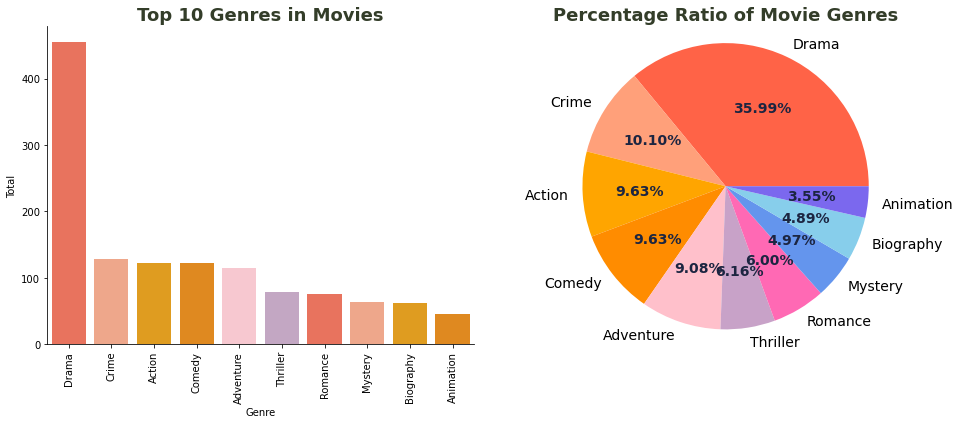

In [8]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df_plot = pd.DataFrame(Counter(genres_list).most_common(10), columns=['Genre', 'Total'])
ax = sns.barplot(data=df_plot, x='Genre', y='Total', ax=axes[0], palette=['#ff6347', '#ffa07a', '#ffa500', '#ff8c00', '#ffc0cb', '#C8A2C8'])
ax.set_title('Top 10 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')

total_top_10 = df_plot['Total'].sum()

wedges, texts, autotexts = axes[1].pie(x=df_plot['Total'], labels=df_plot['Genre'], autopct='%.2f%%',
                                      textprops=dict(fontsize=14), colors=['#ff6347', '#ffa07a', '#ffa500', '#ff8c00', '#ffc0cb', '#C8A2C8', '#ff69b4', '#6495ed', '#87ceeb', '#7b68ee'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('equal')

plt.tight_layout()  
plt.show()


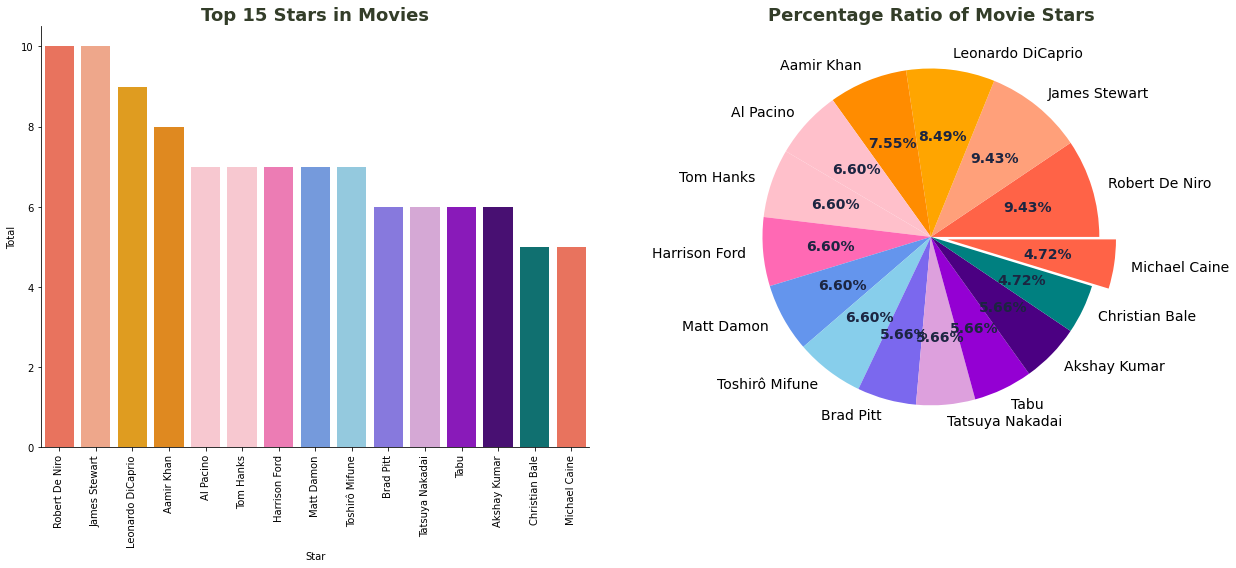

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

stars_list = []
for item in df['Stars']:
    stars_list.extend(item.split(','))  

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

df_plot = pd.DataFrame(Counter(stars_list).most_common(15), columns=['Star', 'Total'])
ax = sns.barplot(data=df_plot, x='Star', y='Total', ax=axes[0], palette=['#ff6347', '#ffa07a', '#ffa500', '#ff8c00', '#ffc0cb', '#ffc0cb', '#ff69b4',
                                              '#6495ed', '#87ceeb', '#7b68ee', '#dda0dd', '#9400d3', '#4b0082', '#008080'])
ax.set_title('Top 15 Stars in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

df_plot = df_plot.dropna()

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.title('Percentage Ratio of Movie Stars', fontsize=18, weight=600, color='#333d29')

explode = [0.1 if i == len(df_plot) - 1 else 0 for i in range(len(df_plot))]

wedges, texts, autotexts = axes[1].pie(x=df_plot['Total'], labels=df_plot['Star'], autopct='%.2f%%',
                                      textprops=dict(fontsize=14), explode=explode,
                                      colors=['#ff6347', '#ffa07a', '#ffa500', '#ff8c00', '#ffc0cb', '#ffc0cb', '#ff69b4',
                                              '#6495ed', '#87ceeb', '#7b68ee', '#dda0dd', '#9400d3', '#4b0082', '#008080'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

plt.tight_layout()  
plt.show()


<AxesSubplot:xlabel='Ratings (../10)', ylabel='count'>

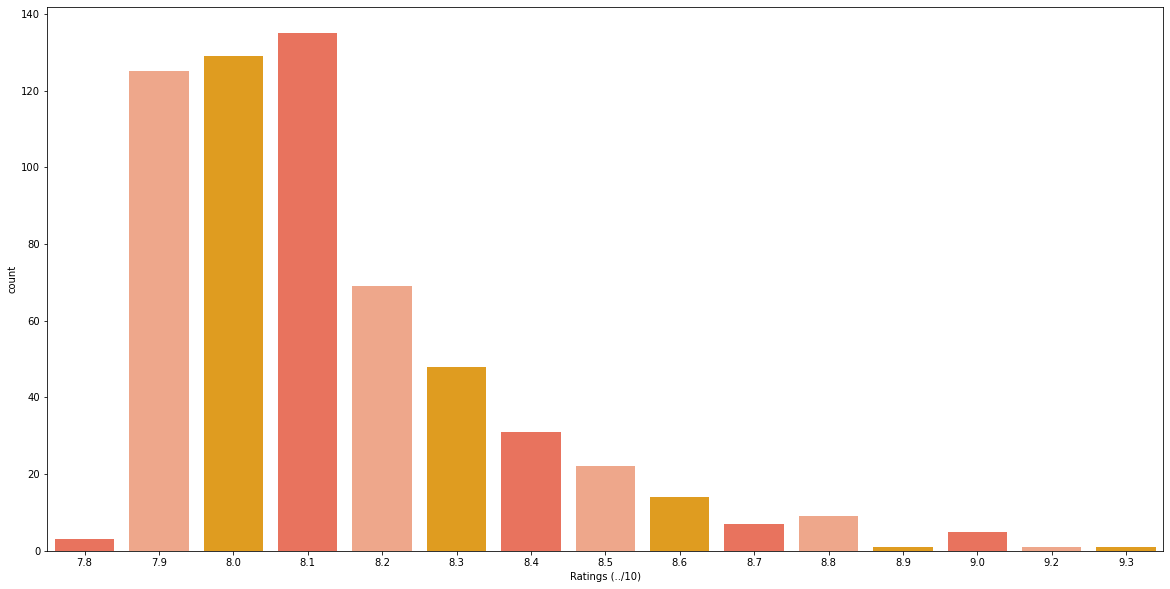

In [10]:
plt.figure(figsize=(20,10))
sns.countplot(x="Ratings (../10)",palette =['#ff6347', '#ffa07a', '#ffa500'], data = df)


In [11]:
top_rates = df.groupby('Movie Genre').mean().sort_values('Ratings (../10)', ascending=False).head(10)
top_rates = top_rates[["Ratings (../10)"]].round(2)
top_rates.reset_index(inplace=True)
print(top_rates)

               Movie Genre  Ratings (../10)
0        Adventure,Western              8.8
1     Drama,Family,Fantasy              8.6
2      Crime,Drama,Fantasy              8.6
3                  Western              8.5
4            Horror,Sci-Fi              8.5
5      Animation,Drama,War              8.5
6               Comedy,War              8.4
7   Action,Adventure,Crime              8.4
8     Action,Drama,Mystery              8.4
9  Animation,Drama,Fantasy              8.4


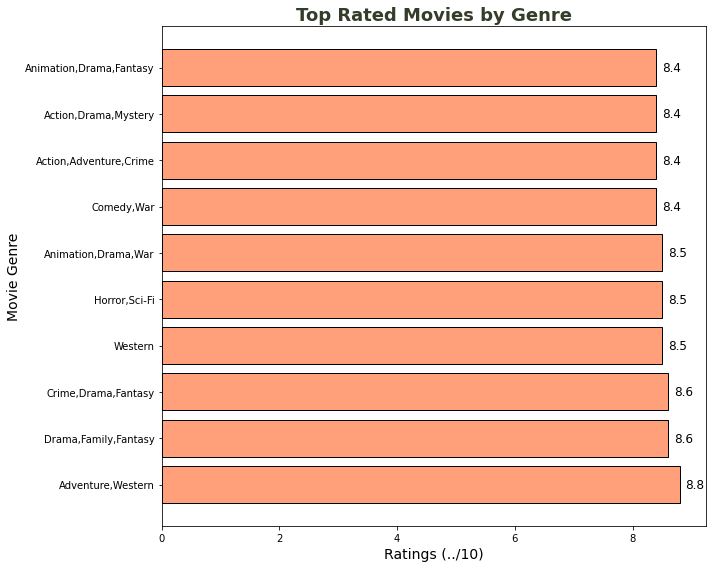

In [12]:
plt.figure(figsize=(10, 8))
plt.barh(top_rates['Movie Genre'], top_rates['Ratings (../10)'], color='#ffa07a', edgecolor='black')
plt.xlabel('Ratings (../10)', fontsize=14)
plt.ylabel('Movie Genre', fontsize=14)
plt.title('Top Rated Movies by Genre', fontsize=18, weight=600, color='#333d29')

for i, v in enumerate(top_rates['Ratings (../10)']):
    plt.text(v + 0.1, i, str(v), va='center', fontsize=12)

plt.tight_layout()
plt.show()


<AxesSubplot:xlabel='Ratings (../10)', ylabel='Gross Collection ($..M)'>

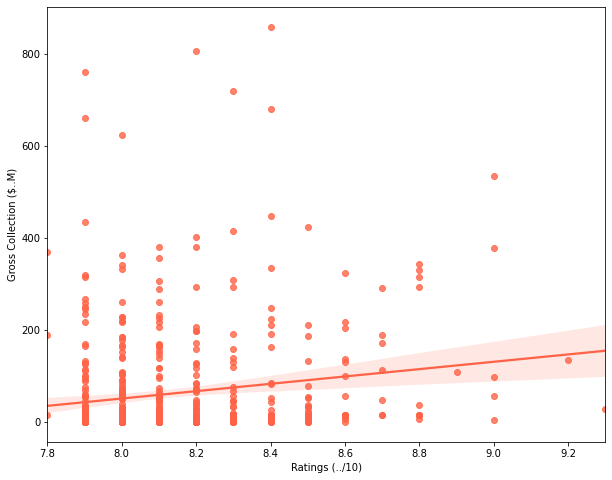

In [13]:
plt.figure(figsize=(10,8))
sns.regplot(x='Ratings (../10)',y='Gross Collection ($..M)',data=df,color='#ff6347')

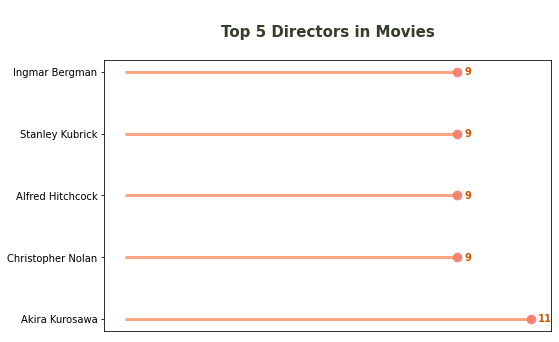

<Figure size 432x288 with 0 Axes>

In [14]:
actors_list = []
for i in df['Director']:
    if i != '':
        actors_list.extend(i.split(', '))
df_plot3 = pd.DataFrame(Counter(actors_list).most_common(5), columns=['Director', 'total']).sort_values(by='total', ascending=False)  # Sort by total in descending order

fig, ax = plt.subplots(figsize=(8, 5))

ax.hlines(y=df_plot3['Director'], xmin=0, xmax=df_plot3['total'], color='#FF7F50', alpha=0.7, linewidth=3)

ax.scatter(x=df_plot3['total'], y=df_plot3['Director'], s=75, color='#F88379')

ax.set_title('\nTop 5 Directors in Movies\n', fontsize=15, weight=600, color='#333d29')

for i, value in enumerate(df_plot3['total']):
    ax.text(value + 0.2, i, value, va='center', fontsize=10, weight=600, color='#CC5500')

ax.set_yticks(df_plot3.index)
ax.set_yticklabels(df_plot3['Director'])

ax.set_xticks([])

plt.show()
sns.despine()
plt.tight_layout()


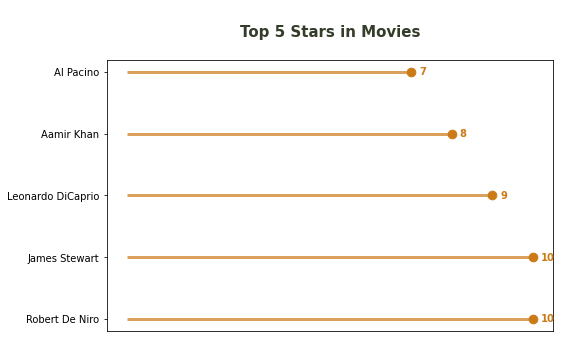

<Figure size 432x288 with 0 Axes>

In [15]:
stars_list = []
for item in df['Stars']:
    stars_list.extend(item.split(','))  
for i in df['Director']:
    if i != '':
        actors_list.extend(i.split(', '))
df_plot3 = pd.DataFrame(Counter(stars_list).most_common(5), columns=['Stars', 'total']).sort_values(by='total', ascending=False)  # Sort by total in descending order

fig, ax = plt.subplots(figsize=(8, 5))

ax.hlines(y=df_plot3['Stars'], xmin=0, xmax=df_plot3['total'], color='#CC7A17', alpha=0.7, linewidth=3)

ax.scatter(x=df_plot3['total'], y=df_plot3['Stars'], s=75, color='#CC7A17')

ax.set_title('\nTop 5 Stars in Movies\n', fontsize=15, weight=600, color='#333d29')

for i, value in enumerate(df_plot3['total']):
    ax.text(value + 0.2, i, value, va='center', fontsize=10, weight=600, color='#CC7A17')

ax.set_yticks(df_plot3.index)
ax.set_yticklabels(df_plot3['Stars'])

ax.set_xticks([])

plt.show()
sns.despine()
plt.tight_layout()


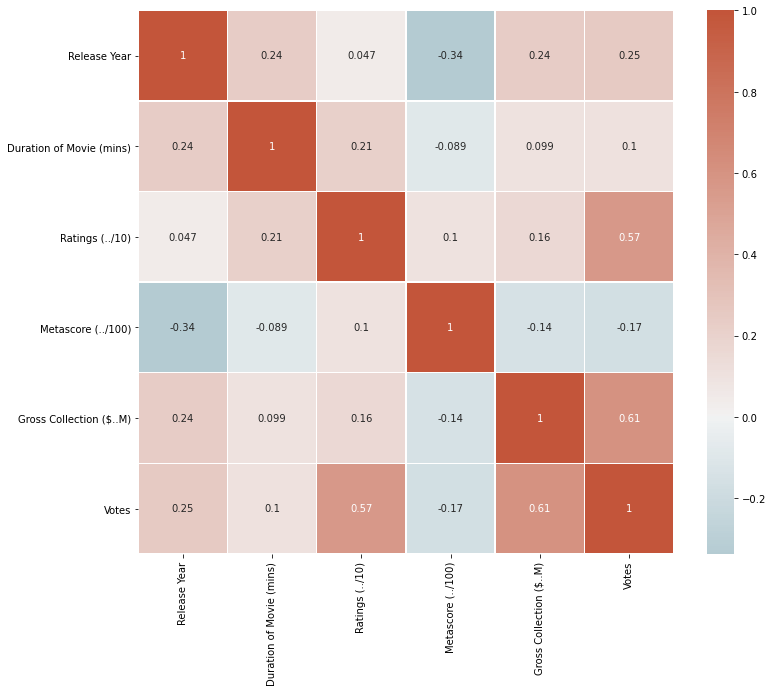

In [16]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=cmap,center=0, linewidths=0.5) 
plt.show()

# Movie Recommendation

In [17]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Movie Name                600 non-null    object 
 1   Release Year              600 non-null    int64  
 2   Duration of Movie (mins)  600 non-null    int64  
 3   Movie Genre               600 non-null    object 
 4   Ratings (../10)           600 non-null    float64
 5   Metascore (../100)        600 non-null    int64  
 6   Director                  600 non-null    object 
 7   Stars                     600 non-null    object 
 8   Gross Collection ($..M)   600 non-null    float64
 9   Votes                     600 non-null    float64
dtypes: float64(3), int64(3), object(4)
memory usage: 47.0+ KB


Movie Name                  0
Release Year                0
Duration of Movie (mins)    0
Movie Genre                 0
Ratings (../10)             0
Metascore (../100)          0
Director                    0
Stars                       0
Gross Collection ($..M)     0
Votes                       0
dtype: int64

In [18]:
df["Stars"] = df["Stars"].str.replace(" ", "")
df["Director"] = df["Director"].str.replace(" ", "")

In [19]:
df.head()

,Movie Name,Release Year,Duration of Movie (mins),Movie Genre,Ratings (../10),Metascore (../100),Director,Stars,Gross Collection ($..M),Votes
0,The Shawshank Redemption,1994,142,Drama,9.3,82,FrankDarabont,"TimRobbins,MorganFreeman,BobGunton,WilliamSadler",28.34,2784045.0
1,The Godfather,1972,175,"Crime,Drama",9.2,100,FrancisFordCoppola,"MarlonBrando,AlPacino,JamesCaan,DianeKeaton",134.97,1938523.0
2,The Dark Knight,2008,152,"Action,Crime,Drama",9.0,84,ChristopherNolan,"ChristianBale,HeathLedger,AaronEckhart,Michael...",534.86,2762699.0
3,Schindler's List,1993,195,"Biography,Drama,History",9.0,95,StevenSpielberg,"LiamNeeson,RalphFiennes,BenKingsley,CarolineGo...",96.90,1400786.0
4,12 Angry Men,1957,96,"Crime,Drama",9.0,97,SidneyLumet,"HenryFonda,LeeJ.Cobb,MartinBalsam,JohnFiedler",4.36,826606.0


In [20]:
df['Movie Genre'] = df['Movie Genre'] + ','
df["tags"]=df["Movie Genre"]+df["Stars"]+df["Director"]
new=df.drop(columns=["Movie Genre","Stars","Director"])

In [21]:
new.sample(5)

,Movie Name,Release Year,Duration of Movie (mins),Ratings (../10),Metascore (../100),Gross Collection ($..M),Votes,tags
314,Chak De! India,2007,153,8.1,68,1.11,82755.0,"Drama,Family,Sport,ShahRukhKhan,VidyaMalvade,S..."
393,Annie Hall,1977,93,8.0,92,39.20,271857.0,"Comedy,Romance,DianeKeaton,TonyRoberts,CarolKa..."
271,The Bridge on the River Kwai,1957,161,8.1,87,44.91,227603.0,"Adventure,Drama,War,WilliamHolden,AlecGuinness..."
133,K.G.F: Chapter 2,2022,168,8.3,84,6.60,141682.0,"Action,Crime,Drama,Yash,SanjayDutt,RaveenaTand..."
222,Ratatouille,2007,111,8.1,96,206.45,781685.0,"Animation,Adventure,Comedy,JanPinkava,BradGarr..."


In [22]:
cv = CountVectorizer(max_features=5000,stop_words='english')
vector = cv.fit_transform(new['tags']).toarray()

In [23]:
similarity = cosine_similarity(vector)
similarity

array([[1.        , 0.18257419, 0.16903085, ..., 0.        , 0.16903085,
        0.16903085],
       [0.18257419, 1.        , 0.3086067 , ..., 0.15430335, 0.15430335,
        0.3086067 ],
       [0.16903085, 0.3086067 , 1.        , ..., 0.28571429, 0.28571429,
        0.42857143],
       ...,
       [0.        , 0.15430335, 0.28571429, ..., 1.        , 0.14285714,
        0.28571429],
       [0.16903085, 0.15430335, 0.28571429, ..., 0.14285714, 1.        ,
        0.28571429],
       [0.16903085, 0.3086067 , 0.42857143, ..., 0.28571429, 0.28571429,
        1.        ]])

In [24]:
def recommend(movie):
    index = new[new['Movie Name'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])), reverse=True, key=lambda x: x[1])
    for i in distances[1:6]:
        print(new.iloc[i[0]]['Movie Name'])  

In [25]:
recommend("Fargo")

Reservoir Dogs
Dial M for Murder
The Departed
Joker
Drishyam 2


# Tkinter

In [28]:
window=tk.Tk()
window.title("Movie Recommendation")
w=800
h=400
screen_width=window.winfo_screenwidth()
screen_height=window.winfo_screenheight()
x=(screen_width/2)-(w/2)
y=(screen_height/2)-(h/2)
window.geometry("%dx%d+%d+%d" %(w,h,x,y))

label=Label(window, text="Movie Name:", font=("Courier 15 "))
label.pack(padx=20,pady=20)

box= Entry(window, width= 40)
box.focus_set()
box.pack(padx=30,pady=30)

from tkinter import Text

def recommendo():
    movie = box.get()
    index = new[new['Movie Name'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])), reverse=True, key=lambda x: x[1])
    
    recommendation_text = ""
    for i in distances[1:6]:
        movie_name = new.iloc[i[0]]['Movie Name']
        recommendation_text += f"{movie_name}\n"
    
    result_box = Text(window, bg='black', fg='white', height=10, width=40)
    result_box.insert("1.0", recommendation_text)
    result_box.tag_configure("center", justify='center')
    result_box.tag_add("center", "1.0", "end") 
    result_box.pack()



In [29]:
buton=tk.Button(window, text= "Recommend",font=("Courier 15"),bg='white', fg="black",width= 20, command=recommendo)
buton.pack(padx=2,pady=2)

window.mainloop()